# We test here the ABBA-LSTM algorithm on the Monthly sunspots dataset.

The dataset is available at https://raw.githubusercontent.com/jbrownlee/Datasets/master/monthly-sunspots.csv

This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983).

The units are a count and there are 2,820 observations. The source of the dataset is credited to Andrews & Herzberg (1985).

## Load the dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def get_data(file_name):
    df = pd.read_csv("data/{}.csv".format(file_name))
    return df

In [3]:
df = get_data("monthly-sunspots")
df["Month"] = pd.to_datetime(df["Month"])

In [4]:
df

,Month,Sunspots
0,1749-01-01,58.0
1,1749-02-01,62.6
2,1749-03-01,70.0
3,1749-04-01,55.7
4,1749-05-01,85.0
...,...,...
2815,1983-08-01,71.8
2816,1983-09-01,50.3
2817,1983-10-01,55.8
2818,1983-11-01,33.3


## Data Analysis

Text(0, 0.5, 'number of sunspots')

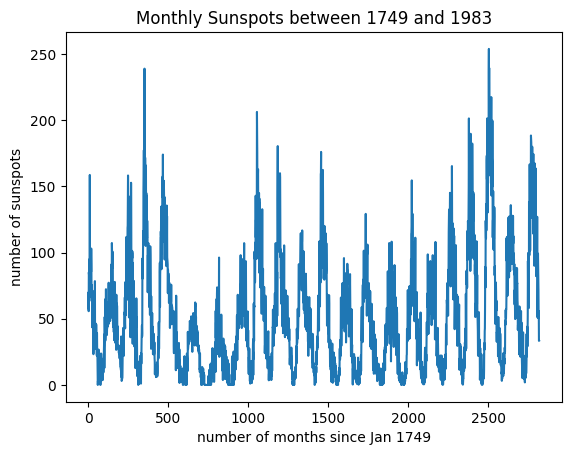

In [5]:
df["Sunspots"].plot()
plt.title("Monthly Sunspots between 1749 and 1983")
plt.xlabel("number of months since Jan 1749")
plt.ylabel("number of sunspots")

Text(0, 0.5, 'number of sunspots')

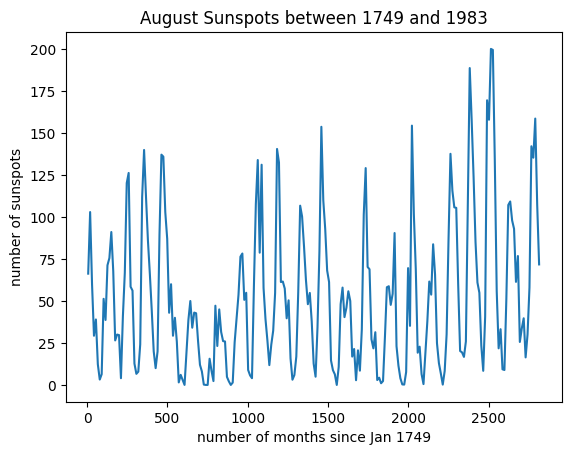

In [6]:
# If we only look the number of sunspots in august of every year:
df[df["Month"].dt.month == 8]["Sunspots"].plot()
plt.title("August Sunspots between 1749 and 1983")
plt.xlabel("number of months since Jan 1749")
plt.ylabel("number of sunspots")

Text(0, 0.5, 'number of sunspots')

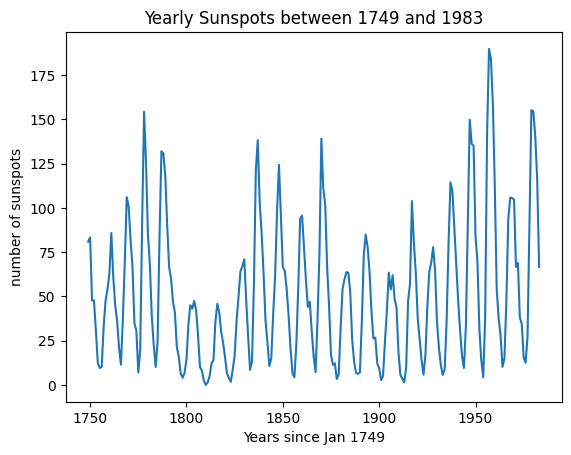

In [7]:
df.groupby(df["Month"].dt.year)["Sunspots"].mean().plot()
plt.title("Yearly Sunspots between 1749 and 1983")
plt.xlabel("Years since Jan 1749")
plt.ylabel("number of sunspots")

In [8]:
df["Relative_Sunspots"] = df["Sunspots"] - df["Month"].dt.year.map(
    df.groupby(df["Month"].dt.year)["Sunspots"].mean()
)

Text(0, 0.5, 'number of sunspots')

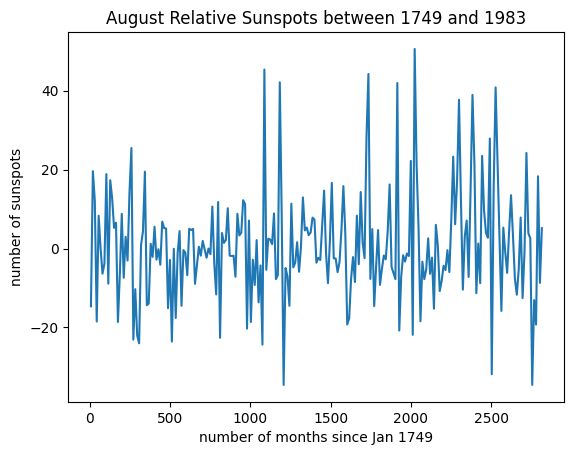

In [9]:
df[df["Month"].dt.month == 8]["Relative_Sunspots"].plot()
plt.title("August Relative Sunspots between 1749 and 1983")
plt.xlabel("number of months since Jan 1749")
plt.ylabel("number of sunspots")

We can see from the plots above that there is not only a high variance between the different months of the year but also a high variance between the mean number of sunspots from one year to another. If we look at the relative number of sunspots, we can see that August is not the month with the most sunspots overall. We can still see though some sort of periodicity in the data.

## Preprocessing

Since some months are unusually sunny sometimes, we decide to smooth the data by taking the mean over the previous month and the next month

Text(0, 0.5, 'number of sunspots')

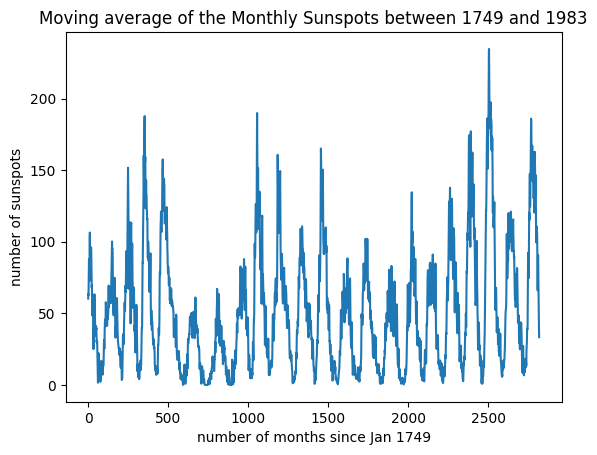

In [10]:
df["ra_Sunspots"] = df["Sunspots"].rolling(3, center=True, min_periods=1).mean()
df["ra_Sunspots"].plot()
plt.title("Moving average of the Monthly Sunspots between 1749 and 1983")
plt.xlabel("number of months since Jan 1749")
plt.ylabel("number of sunspots")

In [11]:
# We normalize the data to better analize it
df["norm_Sunspots"] = (df["ra_Sunspots"] - df["ra_Sunspots"].mean()) / df[
    "ra_Sunspots"
].std()

Text(0, 0.5, 'number of sunspots')

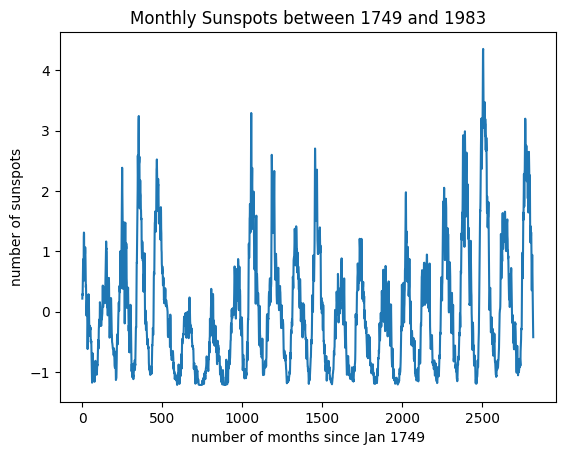

In [12]:
df["norm_Sunspots"].plot()
plt.title("Monthly Sunspots between 1749 and 1983")
plt.xlabel("number of months since Jan 1749")
plt.ylabel("number of sunspots")

In [13]:
from scipy.signal import spectrogram
from numpy.fft import rfft, rfftfreq

N = len(df["norm_Sunspots"])
FS = 1

f, t, Sxx = spectrogram(df["norm_Sunspots"], fs=FS, nperseg=100)

Text(0.5, 1.0, 'Spectrogram of Sunspots')

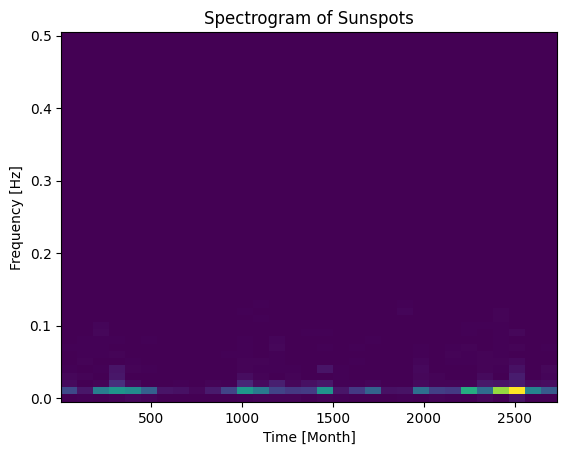

In [14]:
plt.pcolormesh(t, f, Sxx)
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [Month]")
plt.title("Spectrogram of Sunspots")

Text(0.5, 1.0, 'Periodogram')

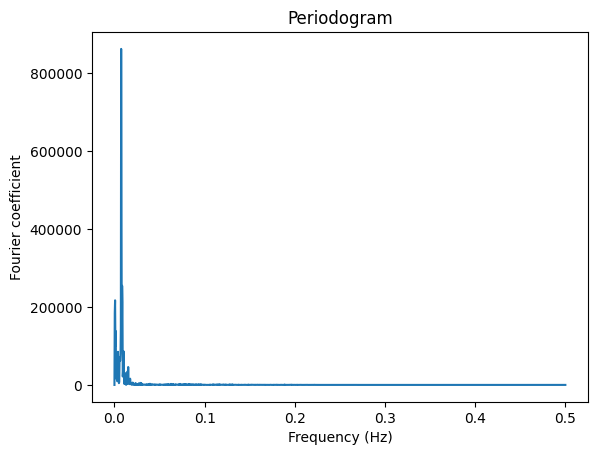

In [15]:
fourier = abs(rfft(df["norm_Sunspots"])) ** 2
freqs = rfftfreq(n=N, d=1.0 / FS)
plt.plot(freqs, fourier)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Fourier coefficient")
plt.title("Periodogram")

In [16]:
print(f"The frequency that appears the most:{freqs[np.argmax(fourier)]: .3f} Hz")

The frequency that appears the most: 0.007 Hz


As we can see on the plot, the signal is periodic  as expected but with a main period of 132 months. This means that the cycle is renewed every 11 years instead of each year. This coincides from physical observations of the solar cycle.

As seen before, we should not expect high frequencies since most months are not particularly more sunny than others. We can see it better with the autocorrelation plot showed below.

Text(0.5, 0, 'Lag (Months)')

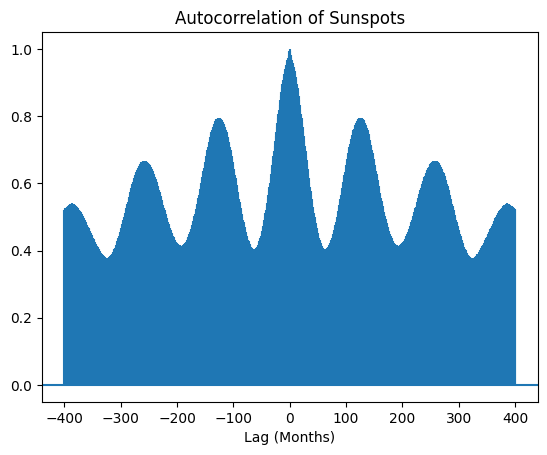

In [17]:
plt.acorr(df["ra_Sunspots"], usevlines=True, normed=True, maxlags=400)
plt.title("Autocorrelation of Sunspots")
plt.xlabel("Lag (Months)")

## Symbolic Representation

In [18]:
time_series = df["norm_Sunspots"].values.astype(np.float32)

In [19]:
from src.abba import ABBA

abba = ABBA(increment_threshold=0.03, max_length=10, max_cluster_size=100)

nb of linear pieces:  1010


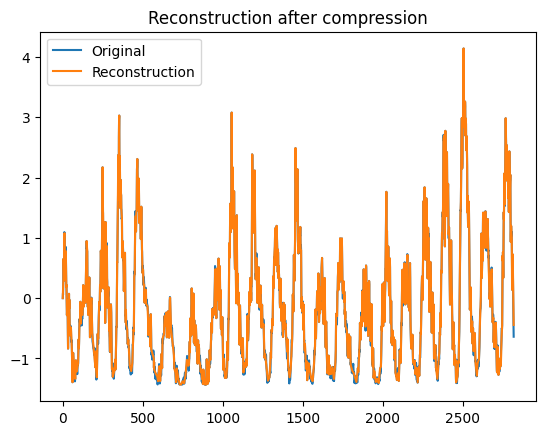

In [20]:
standardized_time_series = abba.standardize(time_series)
linear_pieces = abba.get_linear_pieces(standardized_time_series)
print("nb of linear pieces: ", len(linear_pieces))
plt.plot(standardized_time_series)
plt.plot(abba.unfold_linear_pieces(linear_pieces))
plt.title("Reconstruction after compression")
plt.legend(["Original", "Reconstruction"])

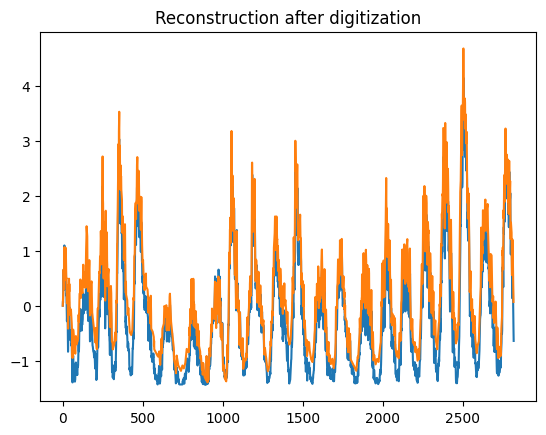

In [21]:
labels, _, _ = abba.learn_transform(standardized_time_series)
string_representation = abba.apply_transform_to_str(standardized_time_series)

reconstructed_linear = abba.apply_inverse_transform_from_str(string_representation)

plt.plot(standardized_time_series)
plt.plot(reconstructed_linear)
plt.title("Reconstruction after digitization")
plt.show()

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

DTW after compressession:  0.01989786621515921
DTW after digitization:  0.09957101265251098


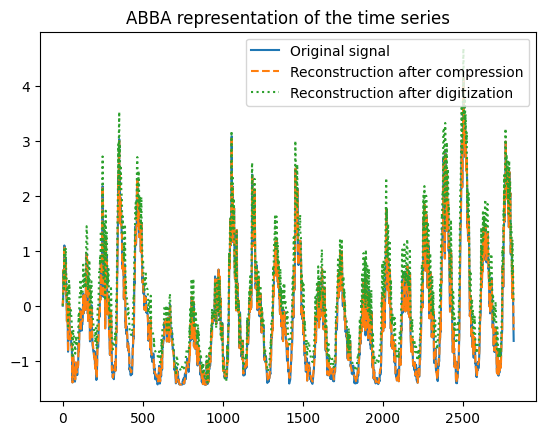

In [22]:
from dtw import dtw

print(
    "DTW after compressession: ",
    dtw(
        standardized_time_series, abba.unfold_linear_pieces(linear_pieces)
    ).normalizedDistance,
)
print(
    "DTW after digitization: ",
    dtw(standardized_time_series, reconstructed_linear).normalizedDistance,
)

plt.plot(standardized_time_series)


plt.plot(abba.unfold_linear_pieces(linear_pieces), linestyle="--")
plt.plot(reconstructed_linear, linestyle=":")
plt.title("ABBA representation of the time series")
plt.legend(
    [
        "Original signal",
        "Reconstruction after compression",
        "Reconstruction after digitization",
    ],
    loc="upper right",
)

## ABBA Training

In [23]:
from src.forecasting.dataset import get_datasets_and_loaders

batch_size = 32


test_split_ratio = 0.2
sequence_length = 20


abba = ABBA(increment_threshold=0.01, max_length=10, max_cluster_size=100)

standardized_time_series = abba.standardize(time_series)

raw_train, raw_test, train_loader, test_loader = get_datasets_and_loaders(
    standardized_time_series,
    batch_size=batch_size,
    test_split_ratio=test_split_ratio,
    sequence_length=sequence_length,
    num_workers=0,
    abba=abba,
)

Average time series length per symbol: 1.4970139349701395


In [24]:
from src.forecasting.models import ABBAForecastingLSTM
from src.forecasting.training import train_loop, accuracy, mse, test_loop
import torch

model = ABBAForecastingLSTM(
    language_size=len(abba.language),
    hidden_size=64,
    num_layers=2,
)


loss_function = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_accuracy = train_loop(
        model,
        train_loader,
        optimizer,
        loss_function,
        accuracy,
        device=torch.device("cpu"),
    )

    test_loss, test_accuracy = test_loop(
        model,
        test_loader,
        loss_function,
        accuracy,
        device=torch.device("cpu"),
    )

    print(
        f"Epoch {epoch} - Train Loss: {train_loss:.3f} - Train Accuracy: {train_accuracy:.3f} - Test Loss: {test_loss:.3f} - Test Accuracy: {test_accuracy:.3f}"
    )

Epoch 0 - Train Loss: 0.005 - Train Accuracy: 0.048 - Test Loss: 0.138 - Test Accuracy: 0.020
Epoch 1 - Train Loss: 0.005 - Train Accuracy: 0.041 - Test Loss: 0.137 - Test Accuracy: 0.025
Epoch 2 - Train Loss: 0.005 - Train Accuracy: 0.039 - Test Loss: 0.137 - Test Accuracy: 0.030
Epoch 3 - Train Loss: 0.005 - Train Accuracy: 0.042 - Test Loss: 0.137 - Test Accuracy: 0.018
Epoch 4 - Train Loss: 0.005 - Train Accuracy: 0.043 - Test Loss: 0.137 - Test Accuracy: 0.033
Epoch 5 - Train Loss: 0.005 - Train Accuracy: 0.062 - Test Loss: 0.137 - Test Accuracy: 0.023
Epoch 6 - Train Loss: 0.006 - Train Accuracy: 0.069 - Test Loss: 0.137 - Test Accuracy: 0.033
Epoch 7 - Train Loss: 0.006 - Train Accuracy: 0.075 - Test Loss: 0.138 - Test Accuracy: 0.020
Epoch 8 - Train Loss: 0.005 - Train Accuracy: 0.094 - Test Loss: 0.138 - Test Accuracy: 0.013
Epoch 9 - Train Loss: 0.005 - Train Accuracy: 0.112 - Test Loss: 0.138 - Test Accuracy: 0.023
Epoch 10 - Train Loss: 0.005 - Train Accuracy: 0.114 - Test 

Evaluate the results both quantitatively and qualitatively

Autoregressive prediction DTW:  0.31855357617020064
Non Autoregressive prediction DTW:  0.357183981379522


Text(0.5, 1.0, 'ABBA-LSTM forecasting on Sunspots')

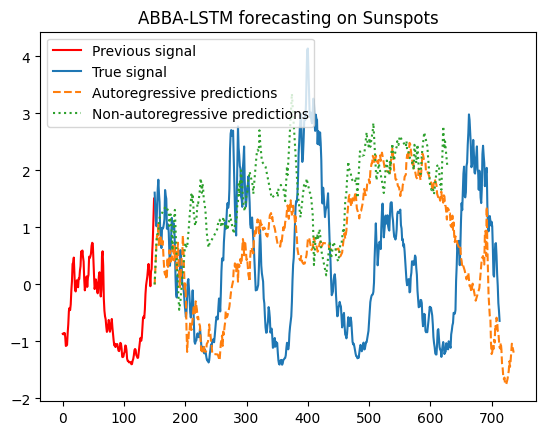

In [25]:
from src.forecasting.training import forecast

autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=True, abba=abba
)
non_autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=False, abba=abba
)

print(
    "Autoregressive prediction DTW: ",
    dtw(autoregressive_predictions, raw_test).normalizedDistance,
)
print(
    "Non Autoregressive prediction DTW: ",
    dtw(non_autoregressive_predictions, raw_test).normalizedDistance,
)

plt.plot(raw_train[-150:], color="red")
plt.plot(
    np.arange(len(raw_train[-150:]), len(raw_train[-150:]) + len(raw_test)), raw_test
)
plt.plot(
    np.arange(
        len(raw_train[-150:]), len(raw_train[-150:]) + len(autoregressive_predictions)
    ),
    autoregressive_predictions,
    linestyle="--",
)
plt.plot(
    np.arange(
        len(raw_train[-150:]),
        len(raw_train[-150:]) + len(non_autoregressive_predictions),
    ),
    non_autoregressive_predictions,
    linestyle=":",
)
plt.legend(
    [
        "Previous signal",
        "True signal",
        "Autoregressive predictions",
        "Non-autoregressive predictions",
    ]
)
plt.title("ABBA-LSTM forecasting on Sunspots")

# Comparison with classical LSTM

In [42]:
from src.forecasting.dataset import get_datasets_and_loaders

batch_size = 128


test_split_ratio = 0.2
sequence_length = 260

standardized_time_series = abba.standardize(time_series)

raw_train, raw_test, train_loader, test_loader = get_datasets_and_loaders(
    standardized_time_series,
    batch_size=batch_size,
    test_split_ratio=test_split_ratio,
    sequence_length=sequence_length,
    num_workers=0,
    abba=None,
)

In [43]:
from src.forecasting.models import RegressionForecastingLSTM
from src.forecasting.training import train_loop, accuracy, mse, test_loop
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model = RegressionForecastingLSTM(
    hidden_size=64,
    num_layers=2,
).to(device)

loss_function = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100

for epoch in range(num_epochs):
    train_loss, train_mse = train_loop(
        model,
        train_loader,
        optimizer,
        loss_function,
        mse,
        device=device,
    )

    test_loss, test_mse = test_loop(
        model,
        test_loader,
        loss_function,
        mse,
        device=device,
    )

    print(
        f"Epoch {epoch} - Train Loss: {train_loss*1000:.3f} - Train MSE: {train_mse*1000:.3f} - Test Loss: {test_loss*1000:.3f} - Test MSE: {test_mse*1000:.3f}"
    )

Epoch 0 - Train Loss: 0.400 - Train MSE: 707.256 - Test Loss: 15.758 - Test MSE: 1609.739
Epoch 1 - Train Loss: 0.187 - Train MSE: 321.949 - Test Loss: 6.456 - Test MSE: 676.533
Epoch 2 - Train Loss: 0.229 - Train MSE: 154.588 - Test Loss: 3.583 - Test MSE: 386.741
Epoch 3 - Train Loss: 0.087 - Train MSE: 104.835 - Test Loss: 2.052 - Test MSE: 227.071
Epoch 4 - Train Loss: 0.054 - Train MSE: 83.439 - Test Loss: 1.748 - Test MSE: 190.890
Epoch 5 - Train Loss: 0.102 - Train MSE: 76.952 - Test Loss: 1.437 - Test MSE: 158.357
Epoch 6 - Train Loss: 0.044 - Train MSE: 73.551 - Test Loss: 1.434 - Test MSE: 157.124
Epoch 7 - Train Loss: 0.093 - Train MSE: 70.177 - Test Loss: 1.336 - Test MSE: 145.814
Epoch 8 - Train Loss: 0.080 - Train MSE: 67.509 - Test Loss: 1.290 - Test MSE: 140.821
Epoch 9 - Train Loss: 0.056 - Train MSE: 63.834 - Test Loss: 1.161 - Test MSE: 126.334
Epoch 10 - Train Loss: 0.052 - Train MSE: 60.081 - Test Loss: 1.056 - Test MSE: 114.564
Epoch 11 - Train Loss: 0.040 - Train

Autoregressive prediction DTW:  0.32126209505830383
Non Autoregressive prediction DTW:  0.0681425856941558


Text(0.5, 1.0, 'LSTM forecasting trained on raw data')

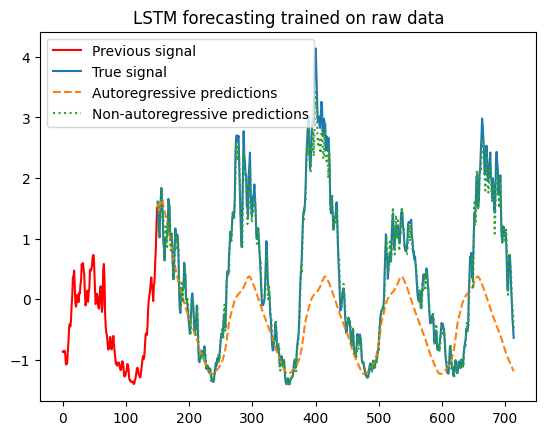

In [44]:
model.to(torch.device("cpu"))

autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=True, abba=None
)
non_autoregressive_predictions = forecast(
    model, test_loader.dataset, auto_regressive=False, abba=None
)

print(
    "Autoregressive prediction DTW: ",
    dtw(autoregressive_predictions, raw_test).normalizedDistance,
)
print(
    "Non Autoregressive prediction DTW: ",
    dtw(non_autoregressive_predictions, raw_test).normalizedDistance,
)


plt.plot(raw_train[-150:], color="red")
plt.plot(
    np.arange(len(raw_train[-150:]), len(raw_train[-150:]) + len(raw_test)), raw_test
)
plt.plot(
    np.arange(
        len(raw_train[-150:]), len(raw_train[-150:]) + len(autoregressive_predictions)
    ),
    autoregressive_predictions,
    linestyle="--",
)
plt.plot(
    np.arange(
        len(raw_train[-150:]),
        len(raw_train[-150:]) + len(non_autoregressive_predictions),
    ),
    non_autoregressive_predictions,
    linestyle=":",
)
plt.legend(
    [
        "Previous signal",
        "True signal",
        "Autoregressive predictions",
        "Non-autoregressive predictions",
    ]
)
plt.title("LSTM forecasting trained on raw data")